In [1033]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import catboost as catb
from lightgbm import LGBMClassifier
import pickle


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


import matplotlib.pyplot as plt


from scipy.stats import shapiro

from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler 


In [1034]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1035]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [1036]:
def transformation(X):
   

    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = X['Bankruptcies'].mode()[0]
    X.loc[X['Current Loan Amount']== 99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].median()
    X.loc[X['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].median()
    X.loc[X['Annual Income'].isna(), 'Annual Income'] = X['Annual Income'].median()
    
    
    X['Term'] = X['Term'].map({'Short Term':'1', 'Long Term':'0'}) # Divid into binary features 
    
    X = pd.get_dummies(X, columns = ['Home Ownership'])
    
    
    X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = X['Months since last delinquent'].mode()[0]
    
    X = pd.get_dummies(X, columns = ['Purpose'])  
    
    
    
            # Заполним данные наиболее часто встречающимися данными.
    X.loc[X['Years in current job'].isna(), 'Years in current job'] = X['Years in current job'].mode()[0]
            
            # Уменьшим количество категорий в 'Years in current job'
    
    X.loc[(X['Years in current job'] == '< 1 year'), 'Years in current job'] = '<1'
    X.loc[(X['Years in current job'] == '1 year') | (X['Years in current job'] == '2 years') | (X['Years in current job'] == '3 years')  | (X['Years in current job'] == '4 years')  | (X['Years in current job'] == '5 years'), 'Years in current job'] = '1-5'
    X.loc[(X['Years in current job'] == '6 years') | (X['Years in current job'] == '7 years')  | (X['Years in current job'] == '8 years')  | (X['Years in current job'] == '9 years'), 'Years in current job']  = '6-9'
    X.loc[(X['Years in current job'] == '10+ years'), 'Years in current job'] = '>10'
    
    X = pd.get_dummies(X, columns = ['Years in current job'])
    
#     # Удалим маловлияющие на целевую переменную данные
    
#     X = X.drop(['Months since last delinquent'], axis = 1)
#     X = X.drop(['Home Ownership_Own Home'], axis = 1)
#     X = X.drop(['Credit Score'], axis = 1)


    # Применим метод главных компонентов для коррелируемых признаков
    
    
    pca = PCA(n_components=1)
    X_new= pca.fit_transform(X.loc[:,['Home Ownership_Rent', 'Home Ownership_Home Mortgage']].values)
    X_new1 = pca.fit_transform(X.loc[:,['Bankruptcies', 'Number of Credit Problems']].values)


    X['PCA_Home Ownership_Rent_AND_Morgage'] = X_new
    X['PCA_Bankruptcies_AND_Number of Credit Problems'] = X_new1
    X  = X.drop(['Home Ownership_Rent', 'Home Ownership_Home Mortgage'], axis = 1)
    X  = X.drop(['Bankruptcies', 'Number of Credit Problems'], axis = 1)
            
            
    
    
    
    return(X)

In [1037]:
ds_cource_train = 'https://salfa.ru/ds/course_project_train.csv'
ds_cource_test = 'https://salfa.ru/ds/course_project_test.csv'

In [1038]:
df = pd.read_csv(ds_cource_train)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


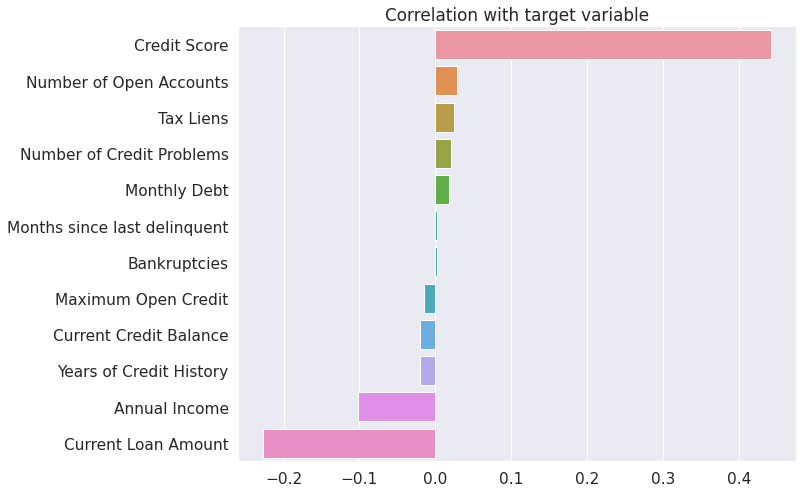

In [1039]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(corr_with_target.values, corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

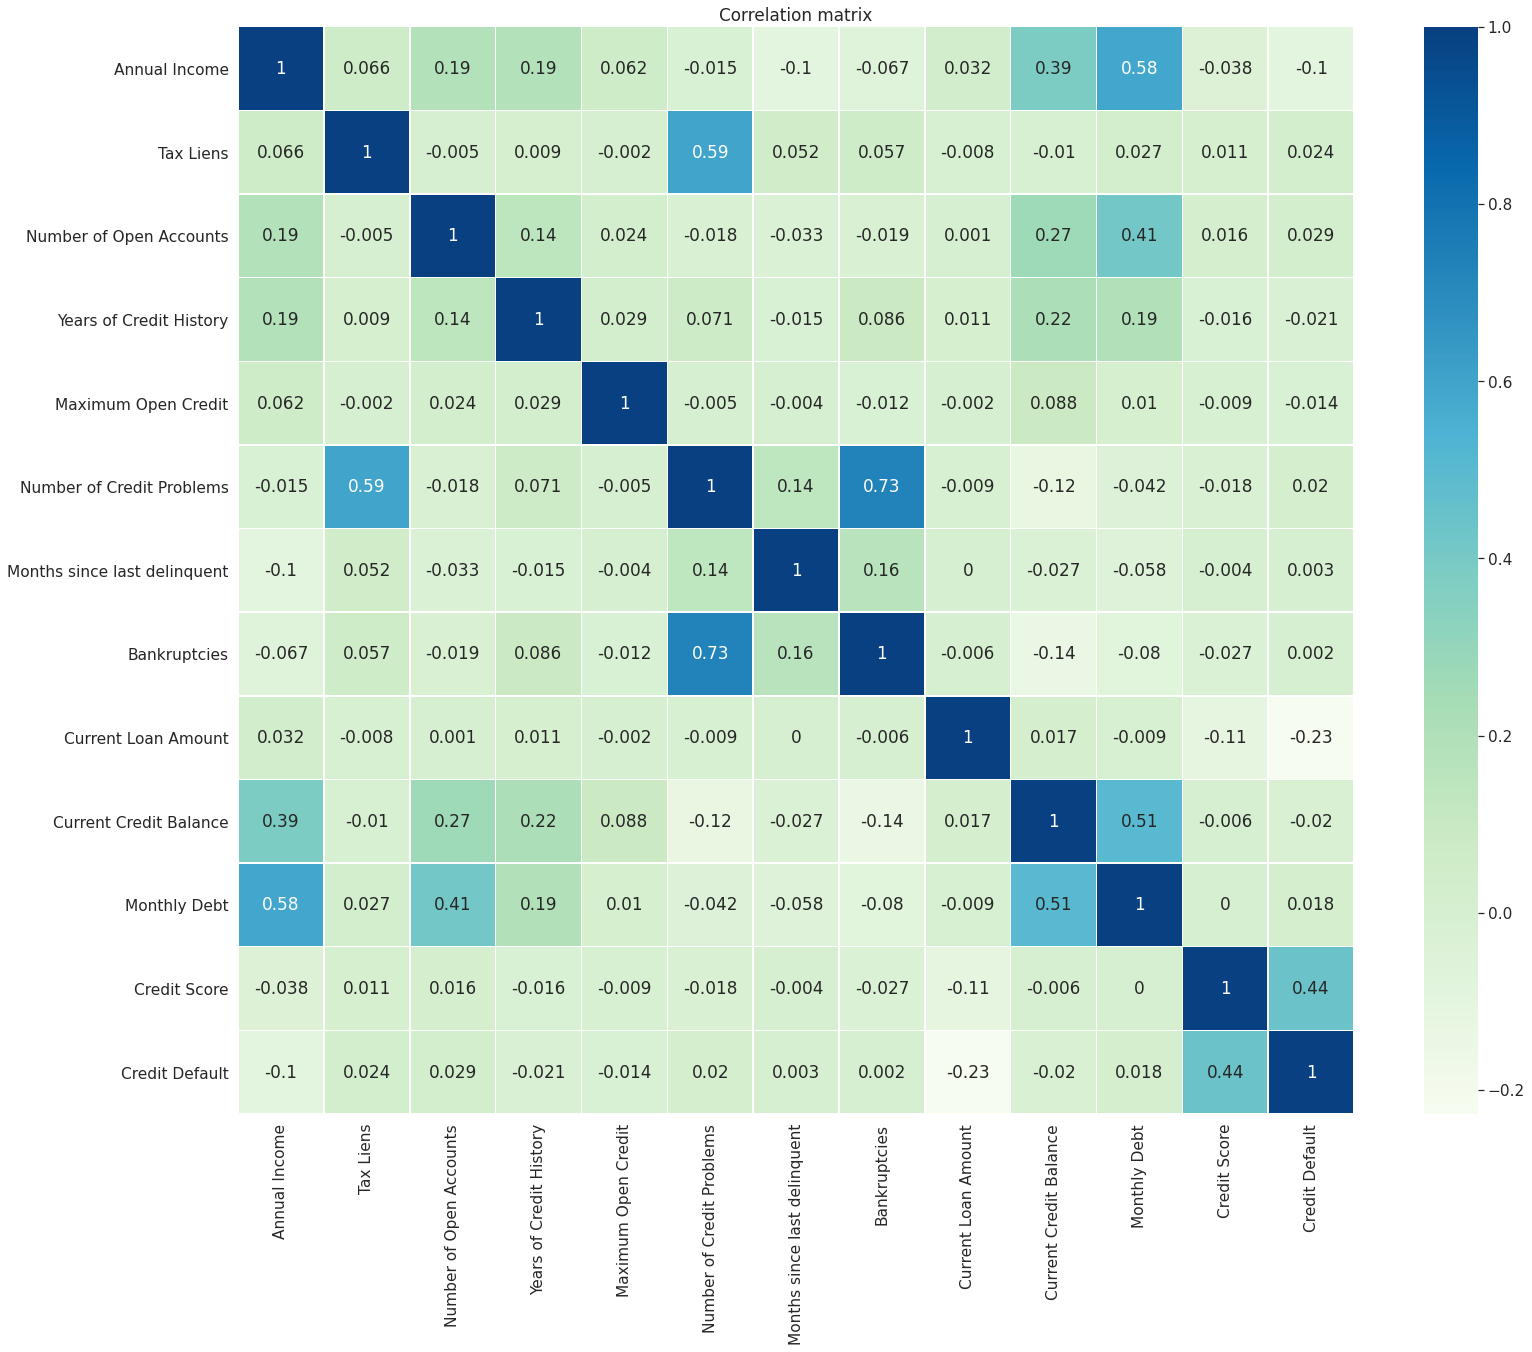

In [1040]:
import seaborn as sns
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [1041]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1042]:
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [1081]:
X_col = ['Home Ownership','Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
         'Number of Credit Problems', 'Months since last delinquent','Bankruptcies','Term', 'Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score', 'Purpose']


X = df[X_col]
y = df['Credit Default']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [1044]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Посмотрим пропуски**

In [1045]:
X['Years in current job'].value_counts()
    

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1046]:
X['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [1047]:
len(X)-X.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Purpose                            0
dtype: int64

In [1048]:
X.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Purpose
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,Short Term,99999999.0,47386.0,7914.0,749.0,debt consolidation
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,Long Term,264968.0,394972.0,18373.0,737.0,debt consolidation
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,Short Term,99999999.0,308389.0,13651.0,742.0,debt consolidation
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,Short Term,121396.0,95855.0,11338.0,694.0,debt consolidation
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,Short Term,125840.0,93309.0,7180.0,719.0,debt consolidation


In [1049]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [1050]:
X['Years in current job'].value_counts()


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1051]:
X['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [1052]:
X.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Purpose
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,Short Term,99999999.0,47386.0,7914.0,749.0,debt consolidation
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,Long Term,264968.0,394972.0,18373.0,737.0,debt consolidation
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,Short Term,99999999.0,308389.0,13651.0,742.0,debt consolidation
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,Short Term,121396.0,95855.0,11338.0,694.0,debt consolidation
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,Short Term,125840.0,93309.0,7180.0,719.0,debt consolidation


In [1053]:
X['Home Ownership'].value_counts(), X['Years in current job'].value_counts()

(Home Mortgage    3637
 Rent             3204
 Own Home          647
 Have Mortgage      12
 Name: Home Ownership, dtype: int64,
 10+ years    2332
 2 years       705
 3 years       620
 < 1 year      563
 5 years       516
 1 year        504
 4 years       469
 6 years       426
 7 years       396
 8 years       339
 9 years       259
 Name: Years in current job, dtype: int64)

In [1054]:
X['Years in current job'] == '2 years'

0       False
1       False
2       False
3       False
4       False
        ...  
7495    False
7496    False
7497    False
7498    False
7499    False
Name: Years in current job, Length: 7500, dtype: bool

In [1055]:
X.groupby(['Years in current job']).mean()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
Years in current job,,,,,,,,,,,,
1 year,1.268811e+06,0.027778,10.920635,16.502381,5.927536e+05,0.123016,35.026549,0.085828,1.333974e+07,255974.069444,16495.539683,1253.218593
10+ years,1.510598e+06,0.034734,11.438250,20.424014,1.084556e+06,0.193825,33.846690,0.137709,1.162431e+07,338754.707118,20326.827187,1150.739645
2 years,1.324517e+06,0.031206,11.007092,16.646667,5.684199e+05,0.153191,34.299320,0.100996,1.273345e+07,258549.601418,16578.445390,1087.280859
3 years,1.396487e+06,0.020968,11.100000,16.618065,2.692149e+06,0.145161,34.670588,0.090323,1.138869e+07,256376.438710,18117.264516,1130.087755
4 years,1.371733e+06,0.021322,10.976546,16.546482,6.040131e+05,0.159915,34.582222,0.113006,1.114110e+07,250922.547974,17528.031983,1134.235135
5 years,1.330786e+06,0.017442,10.775194,17.010465,6.306296e+05,0.145349,36.462555,0.104651,9.770763e+06,272394.052326,18047.511628,1117.742424
6 years,1.311730e+06,0.028169,11.281690,17.136385,6.712647e+05,0.138498,37.080000,0.096471,1.435953e+07,279583.215962,18776.082160,1302.296296
7 years,1.341805e+06,0.035354,11.825758,17.372727,6.092761e+05,0.156566,37.159574,0.106061,1.164777e+07,261129.906566,18356.492424,1172.574675
8 years,1.390800e+06,0.017699,11.528024,18.120059,7.737092e+05,0.156342,32.632653,0.106509,1.443569e+07,308857.386431,19470.988201,1040.425000


# Применим нашу функцию

In [1056]:
X = transformation(X)
X

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1-5,Years in current job_6-9,Years in current job_<1,Years in current job_>10,PCA_Home Ownership_Rent_AND_Morgage,PCA_Bankruptcies_AND_Number of Credit Problems
0,482087.0,0.0,11.0,26.3,685960.0,14.0,1,309573.0,47386.0,7914.0,...,0,0,0,0,0,0,0,1,0.044771,1.169371
1,1025487.0,0.0,15.0,15.3,1181730.0,14.0,0,264968.0,394972.0,18373.0,...,0,0,0,0,0,0,0,1,0.044771,-0.206056
2,751412.0,0.0,11.0,35.0,1182434.0,14.0,1,309573.0,308389.0,13651.0,...,0,0,0,0,0,1,0,0,-0.666651,-0.206056
3,805068.0,0.0,8.0,22.5,147400.0,14.0,1,121396.0,95855.0,11338.0,...,0,0,0,0,0,1,0,0,0.044771,1.169371
4,776264.0,0.0,13.0,13.6,385836.0,14.0,1,125840.0,93309.0,7180.0,...,0,0,0,0,0,1,0,0,0.747536,0.646128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,14.0,1,129360.0,73492.0,1900.0,...,0,0,0,0,0,0,1,0,0.747536,-0.206056
7496,1533984.0,0.0,10.0,26.5,686312.0,43.0,0,444048.0,456399.0,12783.0,...,0,0,0,0,1,0,0,0,-0.666651,-0.206056
7497,1878910.0,0.0,12.0,32.1,1778920.0,14.0,1,309573.0,477812.0,12479.0,...,0,0,0,0,0,1,0,0,0.747536,-0.206056
7498,1168386.0,0.0,21.0,26.5,1141250.0,14.0,1,615274.0,476064.0,37118.0,...,0,0,0,0,0,0,0,1,-0.666651,-0.206056


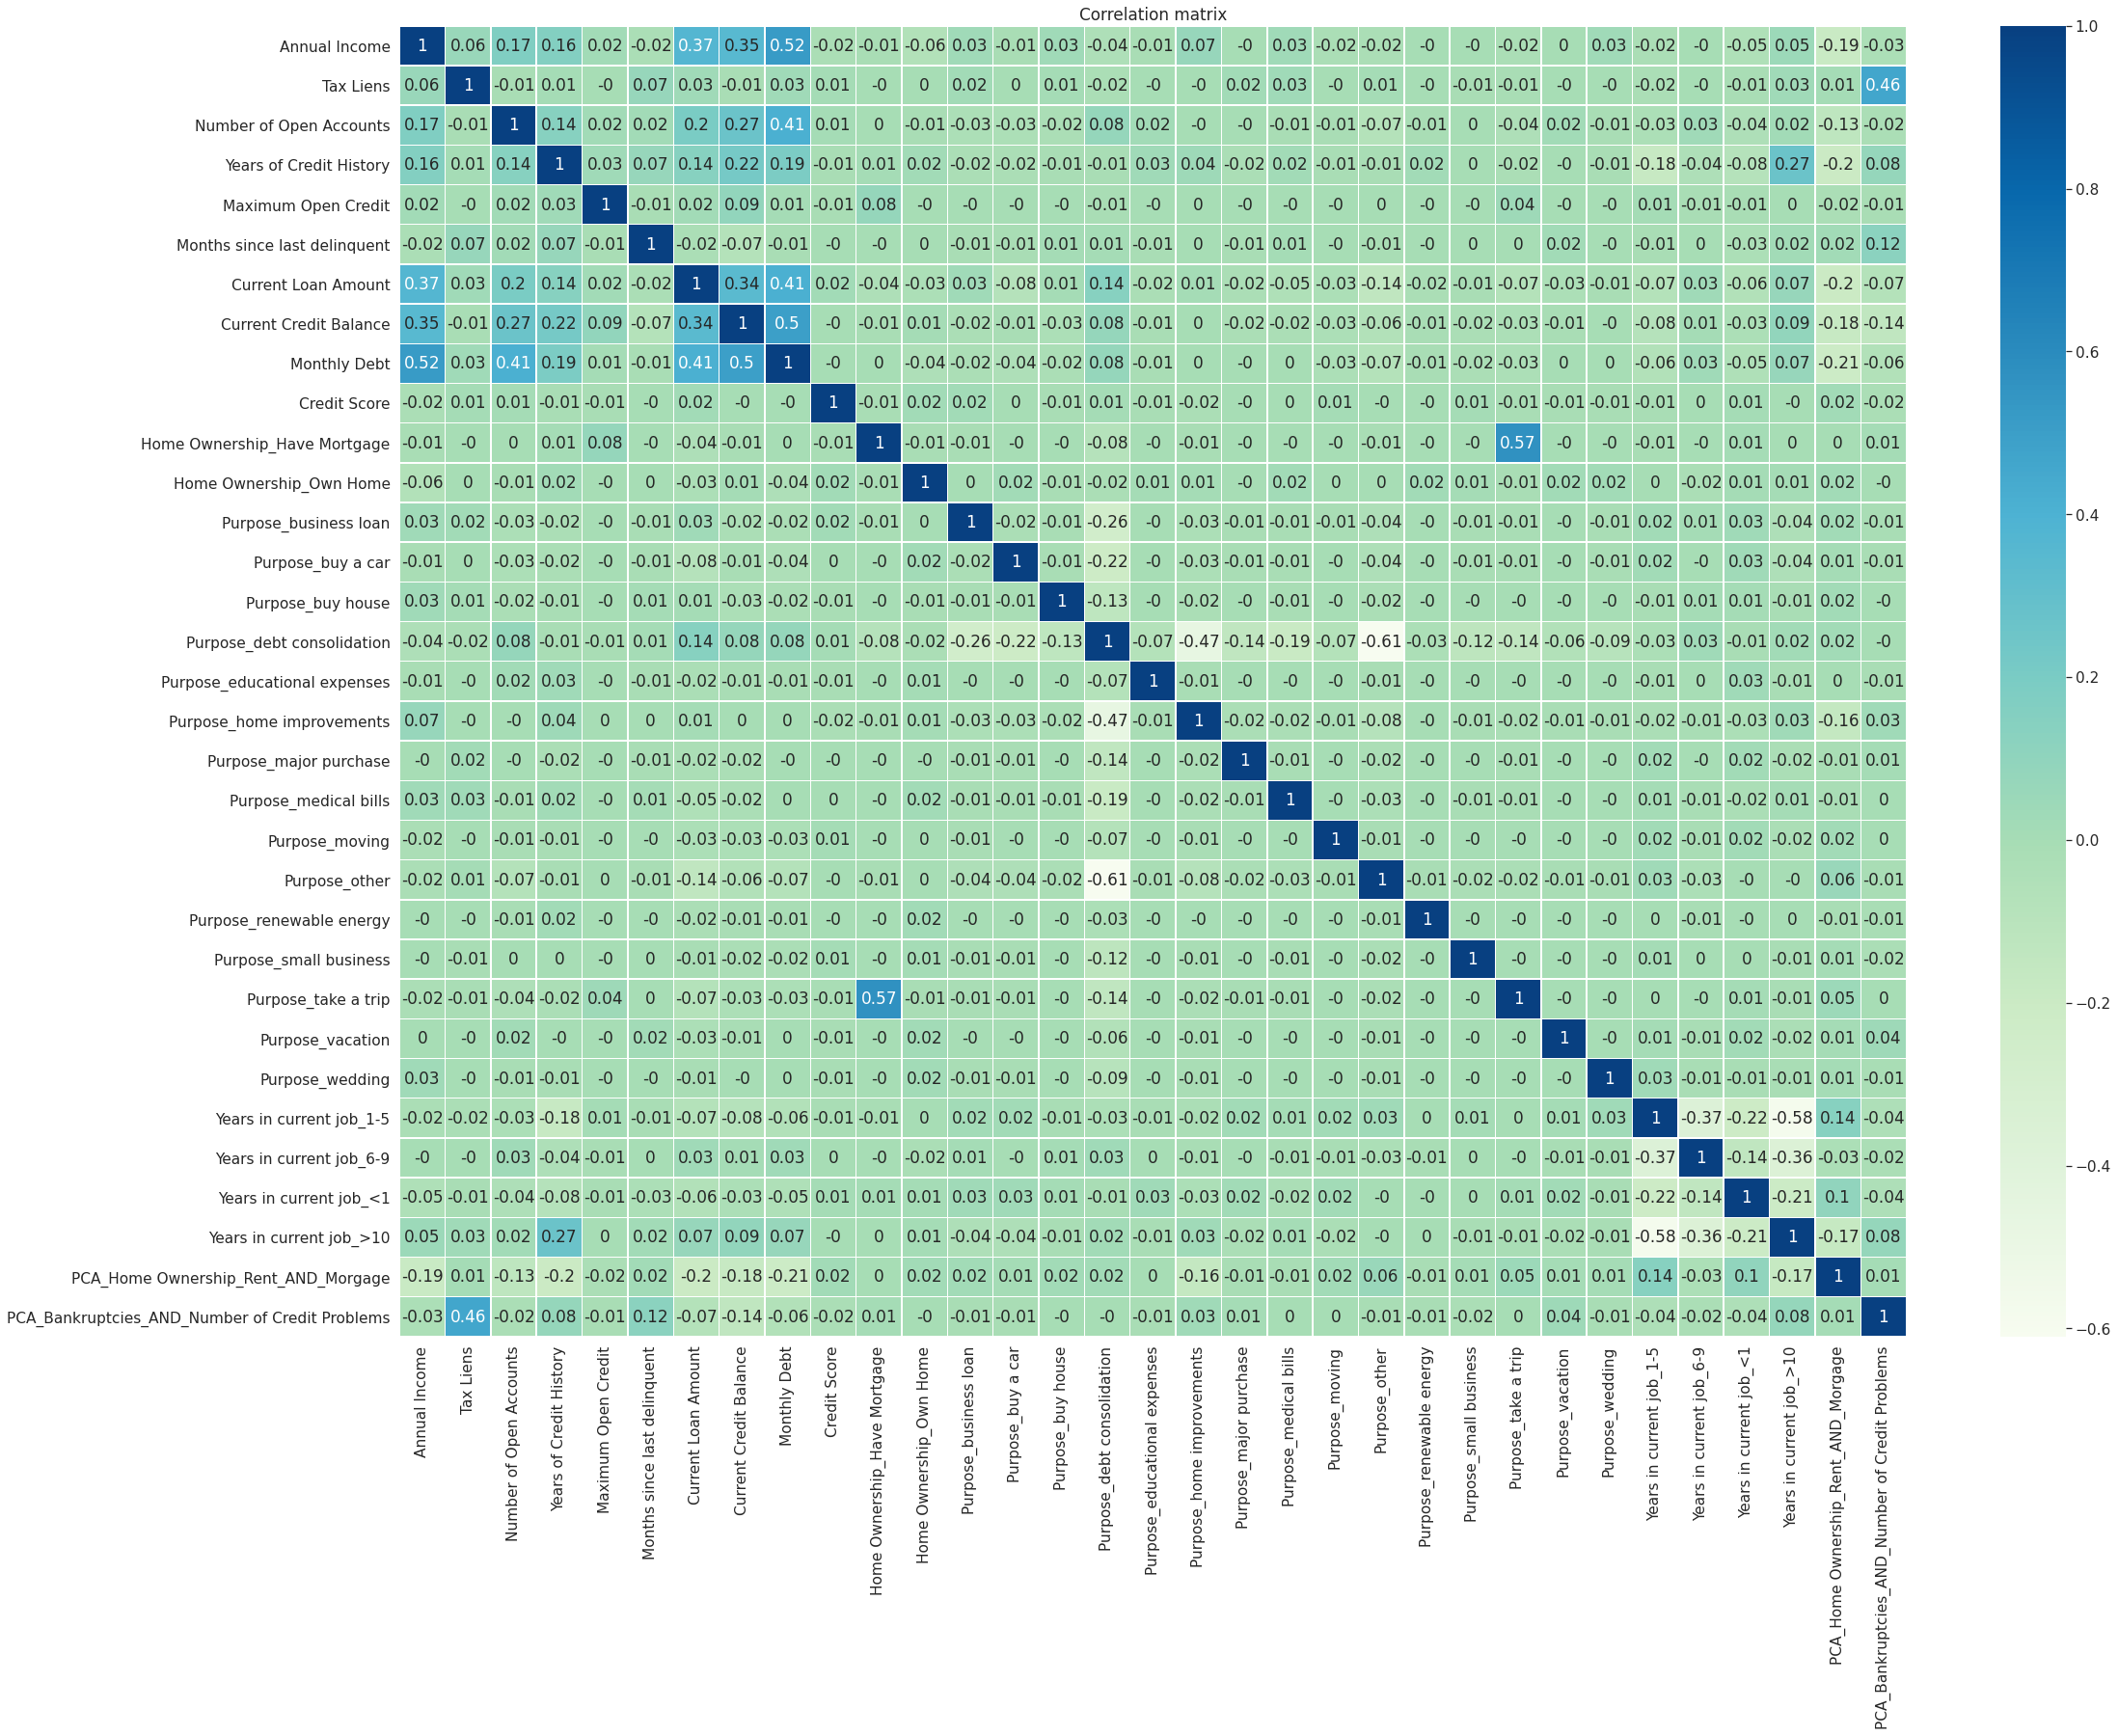

In [1057]:
plt.figure(figsize = (35,25))

sns.set(font_scale=1.4)
sns.heatmap(X.corr().round(2), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

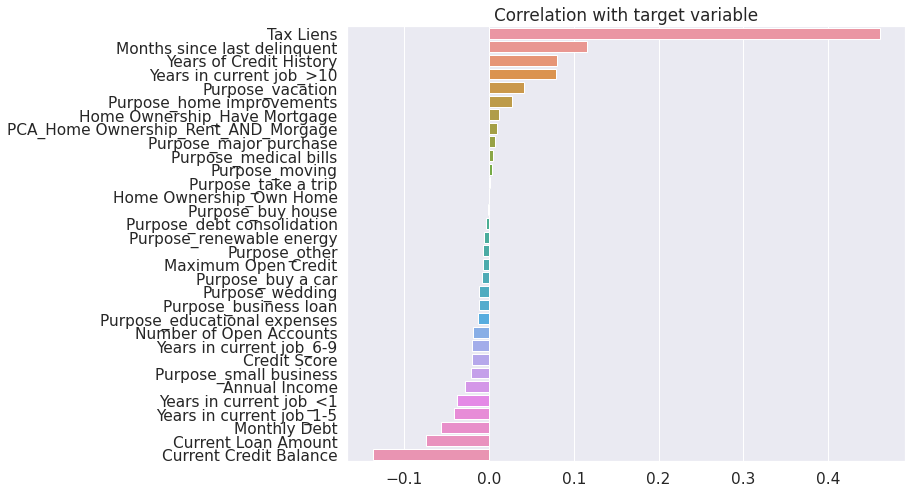

In [1061]:
corr_with_target = X.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(corr_with_target.values, corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [1062]:
X.describe()


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1-5,Years in current job_6-9,Years in current job_<1,Years in current job_>10,PCA_Home Ownership_Rent_AND_Morgage,PCA_Bankruptcies_AND_Number of Credit Problems
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,23.433067,309088.029067,2.898332e+05,18314.454133,1063.877333,...,0.003467,0.004933,0.001067,0.00200,0.375200,0.189333,0.075067,0.360400,2.571277e-16,-8.170575e-16
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,17.906245,171393.740131,3.178714e+05,11926.764673,1438.335832,...,0.058780,0.070069,0.032645,0.04468,0.484207,0.391799,0.263516,0.480148,6.741485e-01,5.711504e-01
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-6.666510e-01,-2.060557e-01
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,14.000000,180169.000000,1.142565e+05,10067.500000,718.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-6.666510e-01,-2.060557e-01
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,14.000000,309567.500000,2.093230e+05,16076.500000,731.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.477104e-02,-2.060557e-01
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,29.000000,396929.500000,3.604062e+05,23818.000000,740.000000,...,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000,7.475361e-01,-2.060557e-01
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,118.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,7.475361e-01,5.953531e+00


In [1063]:
len(X)-X.count()

Annual Income                                     0
Tax Liens                                         0
Number of Open Accounts                           0
Years of Credit History                           0
Maximum Open Credit                               0
Months since last delinquent                      0
Term                                              0
Current Loan Amount                               0
Current Credit Balance                            0
Monthly Debt                                      0
Credit Score                                      0
Home Ownership_Have Mortgage                      0
Home Ownership_Own Home                           0
Purpose_business loan                             0
Purpose_buy a car                                 0
Purpose_buy house                                 0
Purpose_debt consolidation                        0
Purpose_educational expenses                      0
Purpose_home improvements                         0
Purpose_majo

In [1064]:
X.loc[X['Maximum Open Credit']>2.5e+08, 'Maximum Open Credit'] = X['Maximum Open Credit'].mean()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1-5,Years in current job_6-9,Years in current job_<1,Years in current job_>10,PCA_Home Ownership_Rent_AND_Morgage,PCA_Bankruptcies_AND_Number of Credit Problems


In [1066]:
X.loc[X['Months since last delinquent']>90, 'Months since last delinquent'] = X['Months since last delinquent'].mean()
X.loc[X['Months since last delinquent']>90]

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1-5,Years in current job_6-9,Years in current job_<1,Years in current job_>10,PCA_Home Ownership_Rent_AND_Morgage,PCA_Bankruptcies_AND_Number of Credit Problems


In [1067]:
plt.figure(figsize=(15,15))
X = X.drop(['Months since last delinquent'], axis = 1)

<Figure size 1080x1080 with 0 Axes>

In [1068]:
X

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1-5,Years in current job_6-9,Years in current job_<1,Years in current job_>10,PCA_Home Ownership_Rent_AND_Morgage,PCA_Bankruptcies_AND_Number of Credit Problems
0,482087.0,0.0,11.0,26.3,685960.0,1,309573.0,47386.0,7914.0,749.0,...,0,0,0,0,0,0,0,1,0.044771,1.169371
1,1025487.0,0.0,15.0,15.3,1181730.0,0,264968.0,394972.0,18373.0,737.0,...,0,0,0,0,0,0,0,1,0.044771,-0.206056
2,751412.0,0.0,11.0,35.0,1182434.0,1,309573.0,308389.0,13651.0,742.0,...,0,0,0,0,0,1,0,0,-0.666651,-0.206056
3,805068.0,0.0,8.0,22.5,147400.0,1,121396.0,95855.0,11338.0,694.0,...,0,0,0,0,0,1,0,0,0.044771,1.169371
4,776264.0,0.0,13.0,13.6,385836.0,1,125840.0,93309.0,7180.0,719.0,...,0,0,0,0,0,1,0,0,0.747536,0.646128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,1,129360.0,73492.0,1900.0,697.0,...,0,0,0,0,0,0,1,0,0.747536,-0.206056
7496,1533984.0,0.0,10.0,26.5,686312.0,0,444048.0,456399.0,12783.0,7410.0,...,0,0,0,0,1,0,0,0,-0.666651,-0.206056
7497,1878910.0,0.0,12.0,32.1,1778920.0,1,309573.0,477812.0,12479.0,748.0,...,0,0,0,0,0,1,0,0,0.747536,-0.206056
7498,1168386.0,0.0,21.0,26.5,1141250.0,1,615274.0,476064.0,37118.0,731.0,...,0,0,0,0,0,0,0,1,-0.666651,-0.206056


# Разделим датасет на тренировачную и тестовую выборки

In [1071]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [1074]:
final_model = catb.CatBoostClassifier(n_estimators=800, max_depth=2,
                                      class_weights=[1, 2.55],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.82      3631
           1       0.54      0.71      0.61      1394

    accuracy                           0.75      5025
   macro avg       0.71      0.74      0.71      5025
weighted avg       0.78      0.75      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1756
           1       0.48      0.61      0.54       719

    accuracy                           0.69      2475
   macro avg       0.65      0.67      0.65      2475
weighted avg       0.72      0.69      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1282  474
1                281  438


In [1076]:
import  csv

In [1080]:
test_data 

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [1084]:
test_data = pd.read_csv(ds_cource_test)
test_data = transformation(test_data[X_col])

In [1086]:
final_model = catb.CatBoostClassifier(n_estimators=400, max_depth=2,
                                      class_weights=[1, 2.55],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_test_data = final_model.predict(test_data)


In [1089]:
y_test_pred_probs = pd.DataFrame(y_test_data, columns = ['DEFAULTS'])

In [1090]:
filename  = 'Akatov_Denis.1.1.csv'
y_test_pred_probs.to_csv(filename, index=0)